<a href="https://colab.research.google.com/github/Paimonz/computer-vision/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
                                                           #Saiba mais em:

import matplotlib.pyplot as plt                            #https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html
import numpy as np                                         #https://numpy.org/doc/
import tensorflow as tf                                    #https://www.tensorflow.org/api_docs/python/tf
import tensorflow_hub as hub                               #https://www.tensorflow.org/hub?hl=pt-br
from keras.preprocessing.image import ImageDataGenerator   #https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

print('TensorFlow version:', tf.__version__)
print('TensorFlow Hub version:', hub.__version__)

TensorFlow version: 2.12.0
TensorFlow Hub version: 0.14.0


In [2]:
model_name = 'efficientnetv2-b2-21k'

In [3]:
models_path = {
    "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
}

In [4]:
models_pixels = {
    "efficientnetv2-b2-21k": 260
}

In [5]:
model_path = models_path.get(model_name)
model_path


'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2'

In [6]:
pixels = models_pixels.get(model_name)
pixels

260

In [7]:
image_size = (pixels, pixels)
image_size

(260, 260)

In [8]:
print('Model: ', model_name)
print('Path: ', model_path)
print('Imagem size: ', image_size)

Model:  efficientnetv2-b2-21k
Path:  https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2
Imagem size:  (260, 260)


In [9]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
flow_from_directory = "/content/drive/MyDrive/Colab Notebooks/dataset"
data_directory = flow_from_directory
print(data_directory)

/content/drive/MyDrive/Colab Notebooks/dataset


In [13]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_directory,
                                                                    validation_split= .20,
                                                                    subset = 'training',
                                                                    label_mode='categorical',
                                                                    seed = 123,
                                                                    image_size=image_size,
                                                                    batch_size=1)

Found 1050 files belonging to 2 classes.
Using 840 files for training.


In [14]:
train_dataset.class_names

['cataract', 'normal']

In [15]:
classes = train_dataset.class_names
classes

['cataract', 'normal']

In [16]:
training_size = train_dataset.cardinality().numpy()
training_size

840

In [17]:
BATCH_SIZE = 16


In [18]:
train_dataset = train_dataset.unbatch().batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [21]:
840/16


52.5

In [20]:
train_dataset = train_dataset.repeat()

In [22]:
from multiprocessing.process import parent_process
normalization_layer = tf.keras.layers.Rescaling(1. /255)
pre_processing = tf.keras.Sequential([normalization_layer])
pre_processing.add(tf.keras.layers.RandomRotation(40))
pre_processing.add(tf.keras.layers.RandomTranslation(0, 0.2))
pre_processing.add(tf.keras.layers.RandomTranslation(0.2, 0))
pre_processing.add(tf.keras.layers.RandomZoom(0.2, 0.2))
pre_processing.add(tf.keras.layers.RandomFlip(mode = 'horizontal'))

In [23]:
train_dataset = train_dataset.map(lambda images, labels: (pre_processing(images), labels))
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_directory,
                                                                   validation_split= .20,
                                                                   subset ='validation',
                                                                   label_mode ='categorical',
                                                                   seed = 123,
                                                                   image_size = image_size,
                                                                   batch_size = 1)

In [25]:
test_size = test_dataset.cardinality().numpy()
test_size

210

In [26]:
test_dataset = test_dataset.unbatch().batch(BATCH_SIZE)
test_dataset = test_dataset.map(lambda images, labels: (pre_processing(images), labels))

In [27]:
model = tf.keras.Sequential([
                              tf.keras.layers.InputLayer(input_shape= image_size + (3,)),
                              hub.KerasLayer(model_path, trainable = False),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(len(classes))
])

In [28]:
(None, ) + image_size + (3, )

(None, 260, 260, 3)

In [29]:
model.build((None, )+ image_size + (3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1408)              8769374   
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 2)                 2818      
                                                                 
Total params: 8,772,192
Trainable params: 2,818
Non-trainable params: 8,769,374
_________________________________________________________________


In [30]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = 'accuracy')

In [31]:
steps_per_epoch = training_size // BATCH_SIZE
validation_steps = test_size // BATCH_SIZE
print(steps_per_epoch, validation_steps)

52 13


In [32]:
hist = model.fit(train_dataset, epochs= 15, steps_per_epoch = steps_per_epoch,
                 validation_data = test_dataset, validation_steps = validation_steps).history

Epoch 1/15
52/52 [==============================] - 198s 3s/step - loss: 0.5342 - accuracy: 0.8161 - val_loss: 0.1304 - val_accuracy: 0.9423
Epoch 2/15
52/52 [==============================] - 158s 3s/step - loss: 0.2289 - accuracy: 0.9017 - val_loss: 0.1239 - val_accuracy: 0.9712
Epoch 3/15
52/52 [==============================] - 154s 3s/step - loss: 0.1830 - accuracy: 0.9381 - val_loss: 0.1593 - val_accuracy: 0.9423
Epoch 4/15
52/52 [==============================] - 145s 3s/step - loss: 0.1673 - accuracy: 0.9308 - val_loss: 0.1108 - val_accuracy: 0.9423
Epoch 5/15
52/52 [==============================] - 156s 3s/step - loss: 0.1381 - accuracy: 0.9551 - val_loss: 0.1275 - val_accuracy: 0.9471
Epoch 6/15
52/52 [==============================] - 144s 3s/step - loss: 0.1401 - accuracy: 0.9417 - val_loss: 0.0857 - val_accuracy: 0.9712
Epoch 7/15
52/52 [==============================] - 157s 3s/step - loss: 0.1505 - accuracy: 0.9393 - val_loss: 0.0922 - val_accuracy: 0.9615
Epoch 8/15
52

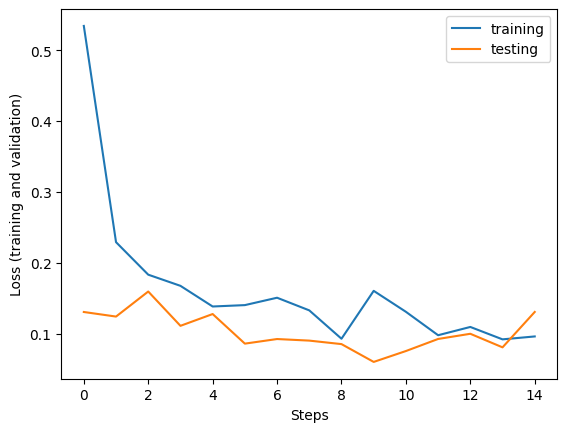

In [34]:
plt.figure()
plt.ylabel('Loss (training and validation)')
plt.xlabel('Steps')
plt.plot(hist['loss'], label = 'training')
plt.plot(hist['val_loss'], label = 'testing')
plt.legend();

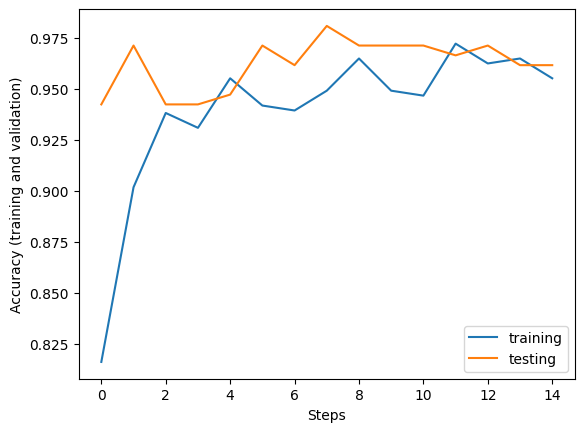

In [35]:
plt.figure()
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Steps')
plt.plot(hist['accuracy'], label = 'training')
plt.plot(hist['val_accuracy'], label = 'testing')
plt.legend();

In [36]:
x, y = next(iter(test_dataset))


In [37]:
x

<tf.Tensor: shape=(16, 260, 260, 3), dtype=float32, numpy=
array([[[[5.55368721e-01, 3.74398410e-01, 2.43082821e-01],
         [5.53983271e-01, 3.73687565e-01, 2.41442323e-01],
         [5.48973560e-01, 3.71700019e-01, 2.37506032e-01],
         ...,
         [5.09032190e-01, 3.72799724e-01, 2.64125228e-01],
         [5.02618074e-01, 3.67168307e-01, 2.60055006e-01],
         [5.06353140e-01, 3.70740891e-01, 2.64353514e-01]],

        [[5.48089683e-01, 3.70696604e-01, 2.40318686e-01],
         [5.48379481e-01, 3.72092545e-01, 2.40577042e-01],
         [5.44457197e-01, 3.71529758e-01, 2.37682611e-01],
         ...,
         [5.12992382e-01, 3.75155836e-01, 2.68975675e-01],
         [5.04573405e-01, 3.66770804e-01, 2.62134075e-01],
         [5.03046095e-01, 3.64920378e-01, 2.60775328e-01]],

        [[5.45076787e-01, 3.67722392e-01, 2.40077466e-01],
         [5.45540750e-01, 3.71932358e-01, 2.41405800e-01],
         [5.43599486e-01, 3.73543859e-01, 2.40326390e-01],
         ...,
         [

In [38]:
x.shape

TensorShape([16, 260, 260, 3])

In [39]:
y

<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

In [40]:
y.shape

TensorShape([16, 2])

In [48]:
image = x[0, :, :, :]
image

<tf.Tensor: shape=(260, 260, 3), dtype=float32, numpy=
array([[[5.5536872e-01, 3.7439841e-01, 2.4308282e-01],
        [5.5398327e-01, 3.7368757e-01, 2.4144232e-01],
        [5.4897356e-01, 3.7170002e-01, 2.3750603e-01],
        ...,
        [5.0903219e-01, 3.7279972e-01, 2.6412523e-01],
        [5.0261807e-01, 3.6716831e-01, 2.6005501e-01],
        [5.0635314e-01, 3.7074089e-01, 2.6435351e-01]],

       [[5.4808968e-01, 3.7069660e-01, 2.4031869e-01],
        [5.4837948e-01, 3.7209255e-01, 2.4057704e-01],
        [5.4445720e-01, 3.7152976e-01, 2.3768261e-01],
        ...,
        [5.1299238e-01, 3.7515584e-01, 2.6897568e-01],
        [5.0457340e-01, 3.6677080e-01, 2.6213408e-01],
        [5.0304610e-01, 3.6492038e-01, 2.6077533e-01]],

       [[5.4507679e-01, 3.6772239e-01, 2.4007747e-01],
        [5.4554075e-01, 3.7193236e-01, 2.4140580e-01],
        [5.4359949e-01, 3.7354386e-01, 2.4032639e-01],
        ...,
        [5.1262295e-01, 3.7270859e-01, 2.6907507e-01],
        [5.0569028e-01

In [49]:
y_true = np.argmax(y[0])
y_true

1

In [50]:
classes[1]

'normal'

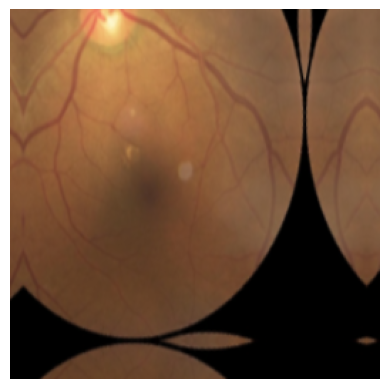

In [51]:
plt.imshow(image)
plt.axis('off');

In [52]:
image.shape

TensorShape([260, 260, 3])

In [53]:
image = np.expand_dims(image, axis = 0)
image.shape

(1, 260, 260, 3)

In [55]:
prediction = model.predict(image)
prediction

1/1 [==============================] - 0s 217ms/step


array([[-4.2770033,  2.5927846]], dtype=float32)

In [ ]:
prediction = np.argmax(prediction)
prediction

1